In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data_no_processing.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import smooth

sample_eddies = [66, 425, 871, 1780, 31, 182, 1602, 2128]

dic_sample = {}
for eddy_ in sample_eddies:
    eddy_ = f'Eddy{eddy_}'
    dic_sample[eddy_] = dic_eddies_vert[eddy_]
    

In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
eddy = 1602 # 2128 1602

df_eddy = df_eddies[df_eddies.Eddy==eddy].copy()
dic = dic_eddies_vert[f'Eddy{eddy}']


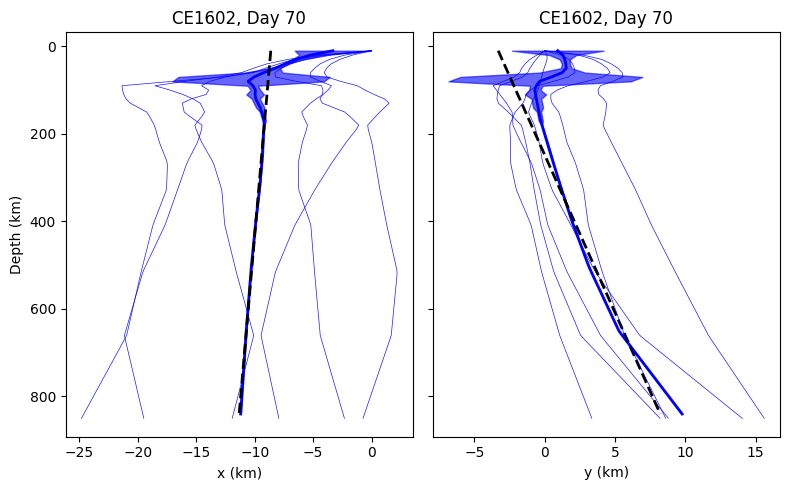

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharey=True)

ref_day = 70 # 2128: 20, 1602: 20
ax0 = axs[0]
ax1 = axs[1]

dic = dic_eddies_vert[f'Eddy{eddy}']
num = 6
depth_int = 10
max_depth = 1000

diffs_x = {}
diffs_y = {}
df_x_interp = {}
df_y_interp = {}
    
for d, day in enumerate(dic.keys()):

    df = dic[day].copy()
    df['Depth'] = df['Depth'].abs()
    df = df[df['Depth'] <= max_depth]
    # don’t drop rows — keep all depths, even if x or y are NaN
    df = df.set_index('Depth').sort_index()

    if len(df):
        depths = df.index.values
        # interpolate at every 10 m from 0 to max_depth
        target_depths = np.arange(0, max_depth+1, depth_int)
        valid = target_depths[
            (target_depths >= depths.min()) &
            (target_depths <= depths.max())
        ]
        if len(valid) < 2:
            continue
    
        x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
        y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)

        df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
        df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
    
        dx = np.diff(x_i)
        dy = np.diff(y_i)
    
        # use the actual depth levels (valid[:-1]) as the Series index
        idx = valid[:-1]
        diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
        diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)

    else:
        idx = [depth_int]
        diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
        diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)

        df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
        df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
        
# now construct your DataFrames simply by passing the dict-of-series:
df_X_all = pd.DataFrame(diffs_x)
df_Y_all = pd.DataFrame(diffs_y)

df_x_interp_all = pd.DataFrame(df_x_interp)
df_y_interp_all = pd.DataFrame(df_y_interp)

df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]

df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]

# Calculation of variability at each depth
df_data = pd.DataFrame()
df_data[r'$\Delta x$'] = df_X.mean(axis=1)
df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
df_data['Depth'] = df_data.index 
df_data

# Line of Best Fit

# your data arrays of shape (N,)
x = df_data[r'$\sum{\Delta x}$'].values
y = df_data[r'$\sum{\Delta y}$'].values
z = df_data['Depth'].values
w = df_data['weight'].values

# 1. compute weighted mean
W = np.sum(w)
mean = np.array([np.dot(w, x),
                 np.dot(w, y),
                 np.dot(w, z)]) / W

# 2. center and weight the data
X = np.vstack((x, y, z)).T
Xc = X - mean
Xw = Xc * np.sqrt(w)[:, None]

# 3. SVD on weighted, centered data
try:
    flag = 0
    _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
except Exception:
    flag = 1
    # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
    
direction = Vt[0]   # principal axis

# The best-fit line is:  p(t) = mean + t * direction
t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
p = mean[None, :] + t[:, None] * direction  # shape (100,3)
# or equivalently
p = mean + np.outer(t, direction)          # also (100,3)

# then split back out if you need x,y,z separately:
x_line, y_line, z_line = p.T

tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])

top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
if top_idx == 1:
    btm_idx = 0
else:
    btm_idx = 1
top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
# tilt_direc = ( bearing(btm, top) + 20 ) % 360

# PLOT
y = df_x_interp.index.to_numpy()

for t in range(df_x_interp.shape[1]):
    xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
    yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
    
    ax0.plot(xt, y, alpha=.9, lw=.5, color='b')
    ax1.plot(yt, y, alpha=.9, lw=.5, color='b')

    if t == 3:
        xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
        ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
        d   = df_data['Depth'].to_numpy()
        tvar = df_data[r'Total $\sigma^2$'].to_numpy()

        theta = np.linspace(0, 2*np.pi, 100)
        cx_mins, cx_maxs, cy_mins, cy_maxs = [], [], [], []
        for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
            cx = xm + rv*np.cos(theta)
            cy = ym + rv*np.sin(theta)
            cz = np.full_like(cx, dm)

            cx_mins.append(cx.min())
            cx_maxs.append(cx.max())
            cy_mins.append(cy.min())
            cy_maxs.append(cy.max())
            
            # ax0.plot(cx, cz, lw=2, color=colors[e])
            # ax1.plot(cy, cz, lw=2, color=colors[e])
        ax0.fill_betweenx(d, cx_mins, cx_maxs, color='b', alpha=0.6)
        ax1.fill_betweenx(d, cy_mins, cy_maxs, color='b', alpha=0.6)

        ax0.plot(xmu, d, color='b', lw=2)
        ax1.plot(ymu, d, color='b', lw=2)

        ax0.plot([top[0], btm[0]], [top[2], btm[2]], color='k', ls='--', lw=2)
        ax1.plot([top[1], btm[1]], [top[2], btm[2]], color='k', ls='--', lw=2)

    ax0.set_xlabel('x (km)')
    ax1.set_xlabel('y (km)')
    ax0.set_ylabel('Depth (km)')

    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax0.set_title(f'{cyc}{eddy}, Day {ref_day}')
    ax1.set_title(f'{cyc}{eddy}, Day {ref_day}')

    # ax0.set_xlim(-50, 50)
    # ax1.set_xlim(-50, 50)

axs[0].invert_yaxis()
plt.tight_layout()
plt.show()


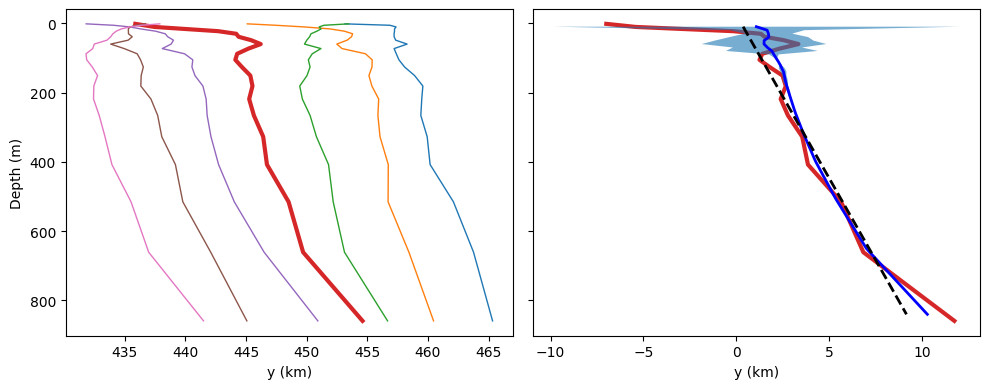

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

ref_day = 40 #70 # 2128: 20, 1602: 20
ax0 = axs[0]
ax1 = axs[1]

dic = dic_eddies_vert[f'Eddy{eddy}']
num = 6
depth_int = 10
max_depth = 1000

diffs_x = {}
diffs_y = {}
df_x_interp = {}
df_y_interp = {}
    
for d, day in enumerate(dic.keys()):

    df = dic[day].copy()
    df['Depth'] = df['Depth'].abs()
    df = df[df['Depth'] <= max_depth]
    # don’t drop rows — keep all depths, even if x or y are NaN
    df = df.set_index('Depth').sort_index()

    if len(df):
        depths = df.index.values
        # interpolate at every 10 m from 0 to max_depth
        target_depths = np.arange(0, max_depth+1, depth_int)
        valid = target_depths[
            (target_depths >= depths.min()) &
            (target_depths <= depths.max())
        ]
        if len(valid) < 2:
            continue
    
        x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
        y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)

        df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
        df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
    
        dx = np.diff(x_i)
        dy = np.diff(y_i)
    
        # use the actual depth levels (valid[:-1]) as the Series index
        idx = valid[:-1]
        diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
        diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)

    else:
        idx = [depth_int]
        diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
        diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)

        df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
        df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
        
# now construct your DataFrames simply by passing the dict-of-series:
df_X_all = pd.DataFrame(diffs_x)
df_Y_all = pd.DataFrame(diffs_y)

df_x_interp_all = pd.DataFrame(df_x_interp)
df_y_interp_all = pd.DataFrame(df_y_interp)

df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]

df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]

# Calculation of variability at each depth
df_data = pd.DataFrame()
df_data[r'$\Delta x$'] = df_X.mean(axis=1)
df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
df_data['Depth'] = df_data.index 
df_data

# Line of Best Fit

# your data arrays of shape (N,)
x = df_data[r'$\sum{\Delta x}$'].values
y = df_data[r'$\sum{\Delta y}$'].values
z = df_data['Depth'].values
w = df_data['weight'].values

# 1. compute weighted mean
W = np.sum(w)
mean = np.array([np.dot(w, x),
                 np.dot(w, y),
                 np.dot(w, z)]) / W

# 2. center and weight the data
X = np.vstack((x, y, z)).T
Xc = X - mean
Xw = Xc * np.sqrt(w)[:, None]

# 3. SVD on weighted, centered data
try:
    flag = 0
    _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
except Exception:
    flag = 1
    # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
    
direction = Vt[0]   # principal axis

# The best-fit line is:  p(t) = mean + t * direction
t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
p = mean[None, :] + t[:, None] * direction  # shape (100,3)
# or equivalently
p = mean + np.outer(t, direction)          # also (100,3)

# then split back out if you need x,y,z separately:
x_line, y_line, z_line = p.T

tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])

top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
if top_idx == 1:
    btm_idx = 0
else:
    btm_idx = 1
top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
# tilt_direc = ( bearing(btm, top) + 20 ) % 360

# PLOT
y = df_x_interp.index.to_numpy()

for t in range(df_x_interp.shape[1]):
    xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
    yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
    
    # ax0.plot(xt, y, alpha=.9, lw=.5)
    # ax1.plot(yt, y, alpha=.9, lw=.5)

    if t == 3:
        xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
        ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
        d   = df_data['Depth'].to_numpy()
        tvar = df_data[r'Total $\sigma^2$'].to_numpy()

        theta = np.linspace(0, 2*np.pi, 100)
        cx_mins, cx_maxs, cy_mins, cy_maxs = [], [], [], []
        for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
            cx = xm + rv*np.cos(theta)
            cy = ym + rv*np.sin(theta)
            cz = np.full_like(cx, dm)

            cx_mins.append(cx.min())
            cx_maxs.append(cx.max())
            cy_mins.append(cy.min())
            cy_maxs.append(cy.max())
            
            # ax0.plot(cx, cz, lw=2, color=colors[e])
            # ax1.plot(cy, cz, lw=2, color=colors[e])
        # ax0.fill_betweenx(d, cx_mins, cx_maxs, alpha=0.6)
        ax1.fill_betweenx(d, cy_mins, cy_maxs, alpha=0.6)

        # ax0.plot(xmu, d, color='b', lw=2)
        ax1.plot(ymu, d, color='b', lw=2)

        # ax0.plot([top[0], btm[0]], [top[2], btm[2]], color='k', ls='--', lw=2)
        ax1.plot([top[1], btm[1]], [top[2], btm[2]], color='k', ls='--', lw=2)

    # ax0.set_xlabel('x (km)')
    ax1.set_xlabel('y (km)')
    # ax0.set_ylabel('Depth (km)')

    # cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    # ax0.set_title(f'{cyc}{eddy}, Day {ref_day}')
    # ax1.set_title(f'{cyc}{eddy}, Day {ref_day}')

    # ax0.set_xlim(-50, 50)
    # ax1.set_xlim(-50, 50)

ax0.invert_yaxis()

df_eddy = df_eddies[df_eddies.Eddy==eddy]
df_int = df_eddy.iloc[ref_day - num // 2:ref_day + num // 2 + 1].copy()
d = 1
for day in dic.keys():
    if int(day[3:]) in df_int.Day.values:
        df_t = dic[day].copy()
        df_t = df_t[df_t.Depth.abs()<1000]
        if int(day[3:]) == df_int.Day.values[len(df_int.Day.values)//2]:
            lw = 3
            ax1.plot(df_t.y-df_t.iloc[0].y-7, df_t.Depth.abs(), lw=lw, color='tab:red', zorder=0)
        else:
            lw = 1
        ax0.plot(df_t.y, df_t.Depth.abs(), lw=lw)
        
        d += 1
ax0.set_xlabel('y (km)'); ax0.set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


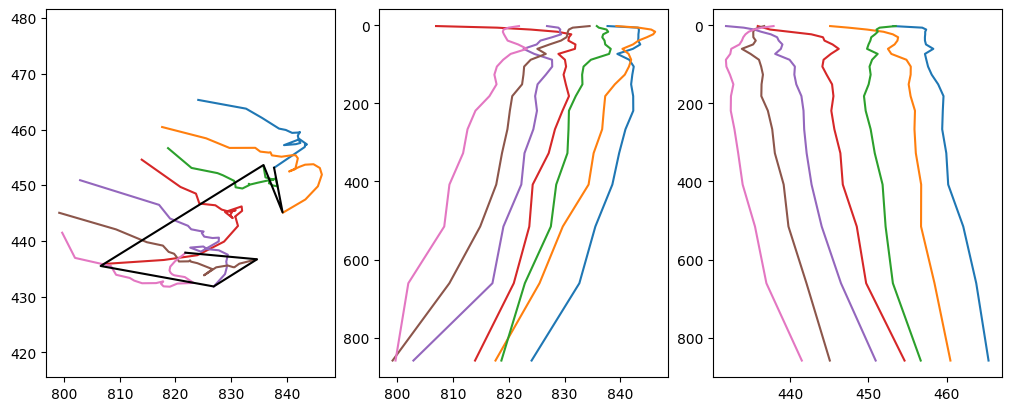

In [13]:
_, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(10,4))
df_eddy = df_eddies[df_eddies.Eddy==eddy]
df_int = df_eddy.iloc[ref_day - num // 2:ref_day + num // 2 + 1].copy()
for day in dic.keys():
    if int(day[3:]) in df_int.Day.values:
        df_t = dic[day].copy()
        df_t = df_t[df_t.Depth.abs()<1000]
        axs[0].plot(df_t.x, df_t.y)
        axs[1].plot(df_t.x, df_t.Depth.abs())
        axs[2].plot(df_t.y, df_t.Depth.abs())
axs[0].plot(df_int.xc, df_int.yc, color='k')
axs[0].axis('equal')

axs[1].invert_yaxis()
axs[2].invert_yaxis()


In [7]:
# days_me = [np.array([5, 17, 26, 37, 51]),
#  np.array([ 0,  5, 10, 17, 24, 28, 31, 41, 58]),
#  np.array([  5,  30, 47,  76,  127, 135]),
#  np.array([30,  51,  68, 103, 137]),
 
#  np.array([ 2, 16, 30, 38, 44, 49, 55, 59, 62, 68]),
#  np.array([  0,    36,  45,  55,  63,  79,  89, 104]),
#  np.array([  10,  33,  44,  50, 66, 114, 130, 143]),
#  np.array([ 0,  16, 19, 21, 25, 40, 49, 55])]

days_me = [np.array([5, 17, 26, 37, 51]),
 np.array([ 0,  5, 10, 17, 24, 28, 31, 41, 58]),
 np.array([  5,  30, 47,  76,  127, 135]),
 np.array([30,  51,  68, 103, 137]),
 
 np.array([ 2, 16, 30, 38, 44, 49, 55, 59, 62, 68]),
 np.array([  0,    36,  45,  55,  63,  79,  89, 104]),
 np.array([  10,  33,  44,  50, 66, 114, 130, 143]),
 np.array([ 0,  16, 19, 21, 25, 40, 49, 55])]

days_p = []
for e, (eddy_, dic) in enumerate(dic_sample.items()):
   
    days = np.array(list(dic.keys()))[days_me[e]]
    days_p.append(days)
    

In [8]:
for eddy_ in sample_eddies:
    eddy_ = f'Eddy{eddy_}'
    dic = dic_sample[eddy_]
    for day in dic.keys():
        df = dic[day]
        if len(df):
            Qs = df['Q'].values.copy()
            Rcs = df['Rc'].values.copy()
            psi0s = df['psi0'].values.copy()
            Rs = df['R'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km
            # smooth against frame index t
            window = 50
            sq11  = smooth([q[0,0] for q in Qs], depths, num=1000, window=window)
            sq12  = smooth([q[0,1] for q in Qs], depths, num=1000, window=window)
            sq22  = smooth([q[1,1] for q in Qs], depths, num=1000, window=window)
            df['sw'] = 2 * (sq11 + sq22)
            df['sQ'] = [np.array([[sq11[i], sq12[i]], [sq12[i], sq22[i]]]) for i in range(len(sq11))]
            df['sRc']   = smooth(Rcs,                    depths, window=window)
            df['spsi0'] = smooth(psi0s,                  depths, window=window)
            df['sR']   = smooth(Rs,                    depths, window=window)


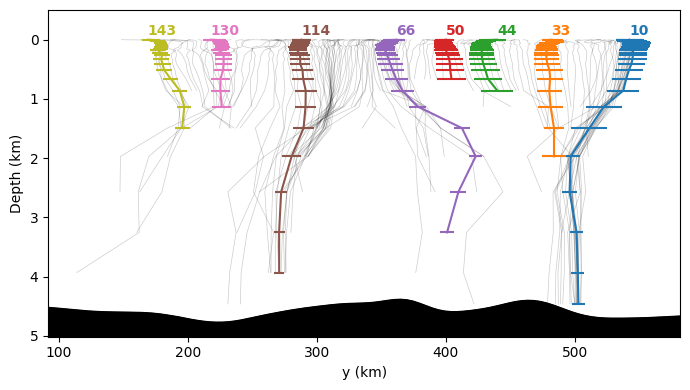

In [9]:
fig, ax = plt.subplots(figsize=(7,4), sharey=True)

# Unique colors for each eddy
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]

colors_v = plt.get_cmap('tab10').colors

if eddy_ in [871, 182, 2128]:
    flagx = True
else:
    flagx = False
days = dic_eddies_vert[f'Eddy{eddy}']
df_all = pd.concat(
    [df0 for df0 in days.values() if not df0.empty and not df0.isna().all().all()],
    ignore_index=True
)
df_mean = pd.DataFrame([{
    'Eddy': eddy,
    'x_mean': df_all['x'].mean(),
    'y_mean': df_all['y'].mean()
}])

dic = dic_eddies_vert[f'Eddy{eddy}']
pmean = df_mean[df_mean.Eddy==eddy].iloc[0]
day_idx = 0
for d, day in enumerate(dic.keys()):
    df = dic[day].copy()
    if len(df):
        if flagx:
            ax.plot(df.x, -df.Depth/1000, linewidth=.5, color='k', alpha=.2,
                        zorder=-1)
            ax.set_xlabel('x (km)')
        else:
            ax.plot(df.y, -df.Depth/1000, linewidth=.5, color='k', alpha=.2,
                        zorder=-1)
        e = np.where(np.array(sample_eddies)==eddy)[0][0]
        if day in days_p[e]:

            if flagx:
                ax.plot(df.x, -df.Depth/1000, color=colors[day_idx % 10],
                        zorder=0 if df.iloc[-1].y > pmean.y_mean else 2)
            else:
                ax.plot(df.y, -df.Depth/1000, color=colors[day_idx % 10],
                        zorder=2 if df.iloc[-1].x > pmean.x_mean else 0)

            # raw data
            xs = df['x'].values.copy()
            ys = df['y'].values.copy()
            sQs = df['sQ'].values.copy()
            sq11 = [q[0,0] for q in sQs]
            sq12 = [q[0,1] for q in sQs]
            sq22 = [q[1,1] for q in sQs]
            sRc = df['sRc'].values.copy()
            sR = df['sR'].values.copy()
            spsi0 = df['spsi0'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km

            for xc, yc, q11, q12, q22, Rc, R, z0 in zip(xs, ys, sq11, sq12, sq22, sRc, sR, depths):
                R /= 7
                if flagx:
                    ax.hlines(z0, xc-R, xc+R, color=colors[day_idx % 10])
                else:
                    ax.hlines(z0, yc-R, yc+R, color=colors[day_idx % 10])

            if flagx:
                ax.text(xs[0], -.08, d, color=colors[day_idx % 10], fontweight='bold')
            else:
                ax.text(ys[0], -.08, d, color=colors[day_idx % 10], fontweight='bold')
                
            day_idx += 1

ax.set_xlabel('y (km)')
xlim = ax.get_xlim()

if flagx:
    jc = np.where(np.abs(pmean.y_mean-y_grid)==np.min(np.abs(pmean.y_mean-y_grid)))[0][0]
    ax.plot(x_grid, h[:, jc]/1000, 'k', zorder=1)
    ylim = ax.get_ylim()
    ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k', zorder=1)
else:
    ic = np.where(np.abs(pmean.x_mean-x_grid)==np.min(np.abs(pmean.x_mean-x_grid)))[0][0]
    ax.plot(y_grid, h[ic, :]/1000, 'k', zorder=1)
    ylim = ax.get_ylim()
    ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k', zorder=1)

# cyc = df_eddies[df_eddies.Eddy==eddy_].iloc[0].Cyc
# ax.set_title(f'{cyc}{eddy_}')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_ylabel('Depth (km)')
        
ax.invert_yaxis()
ax.set_ylim(None, -.5)
plt.tight_layout()


Text(0, 0.5, 'Tilt Distance (km)')

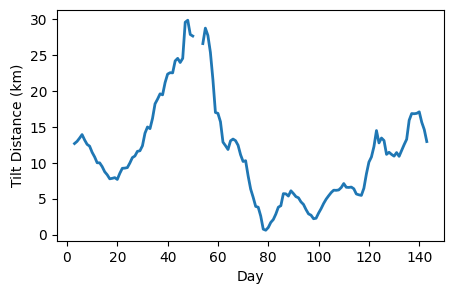

In [10]:
plt.figure(figsize=(5,3))
plt.plot(df_eddy.Day-df_eddy.iloc[0].Day, df_eddy.TiltDis, lw=2)
plt.xlabel('Day'); plt.ylabel('Tilt Distance (km)')


Text(0, 0.5, 'Tilt Direction (°N)')

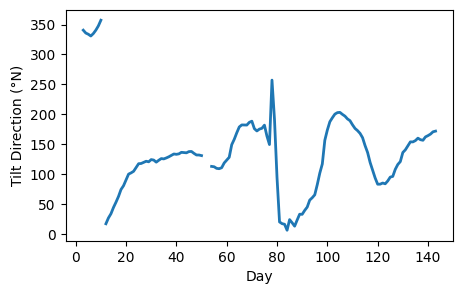

In [11]:
plt.figure(figsize=(5,3))
TDir_diff = df_eddy.TiltDir.copy().diff().abs()
TDir = df_eddy.TiltDir.copy()
TDir[TDir_diff>150] = np.nan
# plt.plot(df_eddy.Day-df_eddy.iloc[0].Day, df_eddy.TiltDir, lw=2)
plt.plot(df_eddy.Day-df_eddy.iloc[0].Day, TDir, lw=2)
plt.xlabel('Day'); plt.ylabel('Tilt Direction (°N)')
